In [1]:
import numpy as np
import tensorflow as tf

# %matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as colors 

import ipysh
import Hunch_utils  as Htls
import Hunch_lsplot as Hplt
import Hunch_tSNEplot as Hsne

# !pip install --user nbmultitask
from nbmultitask import ThreadWithLogAndControls
from nbmultitask import ProcessWithLogAndControls
from IPython.display import clear_output

%aimport Dataset_QSH
%aimport models.base
%aimport models.AEFIT5
%aimport models.GAN3


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

Hunch models imported
reload set for module  Hunch_utils
reload set for module  Dummy_g1data
reload set for module  Hunch_lsplot
reload set for module  Hunch_tSNEplot


In [ ]:
import Dataset_QSH
qsh = Dataset_QSH.Dataset_QSH()
# import os
# file = ipysh.abs_builddir+'/te_db_r15.npy'
# if os.path.isfile(file):
#     qsh.load(file)
# else:
#     qsh.load(ipysh.abs_builddir+'/te_db_2.npy')
#     qsh.rebalance_prel(15)
#     qsh.save(ipysh.abs_builddir+'/te_db_r15.npy')
    
# qsh.shuffle()
# qsh.clean_up_poorcurves(5)
# qsh.dim = 15
# qsh.set_null(np.nan)
# qsh.set_normal_positive()
# qsh.unbias_mean(0.5, 'te')
# qsh.set_normal_positive(['te'])
# qsh.clip_values(0.1,0.6)
# qsh.set_normal_positive(['te'])

qsh.load(ipysh.abs_builddir+'/te_db_r15_clean.npy')
qsh.dim = 15
qsh.set_null(np.nan)

print("QSH rebalanced 15 points size: ", len(qsh))

In [2]:
import Dummy_g1data as dummy
du = dummy.Dummy_g1data(counts=20000, size=15).buffer()
du.kinds

[{'gain': [1, 1], 'mean': [0.2, 0.8], 'sigma': [0.1, 0.1]},
 {'gain': [0.5], 'mean': [0.8], 'sigma': [0.1]},
 {'gain': [0.5], 'mean': [0.2], 'sigma': [0.1]},
 {'gain': [1], 'mean': [0.5], 'sigma': [0.2]},
 {'gain': [0.5], 'mean': [0.5], 'sigma': [0.2]}]

In [26]:
vae = models.AEFIT5.AEFIT5(latent_dim=2, feature_dim=30, dprate=0., scale=1, beta=0., geometry=[5,5])
# vae.compile( loss = tf.keras.losses.mse, logit_loss=True )

AEFIT5 a ready:


In [27]:
vae.train_thread(du, epoch=100, batch=100).control_panel()

EPOCH:  0
test loss:  20.4996543063 
EPOCH:  1
test loss:  20.4337529406 
EPOCH:  2
test loss:  20.2967785579 
EPOCH:  3
test loss:  20.2846389129 
EPOCH:  4
 Train early stopping ... 


tf.Tensor([-0.02368297 -7.1477704   0.93851113], shape=(3,), dtype=float32) tf.Tensor(
[0.03930399 0.10091293 0.15735602 0.21869287 0.27507198 0.34026635
 0.42587563 0.4940034  0.57403594 0.6620263  0.7242019  0.79432213
 0.85887575 0.9125365  0.96756077], shape=(15,), dtype=float32) tf.Tensor(
[1.6248927e-01 3.4755376e-01 4.4673294e-01 4.5012179e-01 3.2581228e-01
 1.5865475e-01 5.5464029e-02 1.5563756e-02 2.3089647e-03 4.1056861e-04
 1.6878500e-04 9.3626273e-05 9.2466711e-05 4.5634268e-04 6.3434581e-04], shape=(15,), dtype=float32)


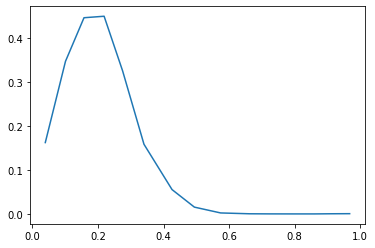

In [29]:
def _map(xy,l):
    xy = tf.reshape(xy, [1,-1])
    m,_ = vae.encode(xy, training=False)
    XY  = vae.decode(m, training=False)
    XY  = tf.clip_by_value(XY, clip_value_min=0., clip_value_max=1.)
    m  = tf.reshape(m, [-1])
    m  = tf.concat([m, tf.random.uniform([1])], axis=0)
    XY = tf.reshape(XY, [-1])
    return (m,XY),l

ds = du.ds_array.map(lambda xy,l: _map(xy,l) )
(mean,xy),_ = [x for x in ds.take(1)][0]
x,y = tf.split(xy, num_or_size_splits=2, axis=0)
print(mean, x, y)
plt.figure('map')
plt.plot(x,y)

In [32]:
r_vae = models.AEFIT5.AEFIT5(latent_dim=3, feature_dim=30, dprate=0., scale=1, beta=0., geometry=[5,5])
r_vae.inference_net = vae.inference_net
r_vae.inference_net.trainable = False
r_vae.generative_net.compile( r_vae.optimizer, r_vae.loss )
r_vae.generative_net.summary()

AEFIT5 a ready:
Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
aefi_t5_11_gRlv (Relevance1D (None, 3)                 3         
_________________________________________________________________
dense_63 (Dense)             (None, 150)               600       
_________________________________________________________________
dropout_40 (Dropout)         (None, 150)               0         
_________________________________________________________________
dense_64 (Dense)             (None, 150)               22650     
_________________________________________________________________
dropout_41 (Dropout)         (None, 150)               0         
_________________________________________________________________
dense_65 (Dense)             (None, 30)                4500      
Total params: 27,753
Trainable params: 27,753
Non-trainable params: 0
_________________________________

In [33]:
dds = ds.map(lambda x,l: (x[0],x[1])).batch(100)
[x for x in dds.take(1)][0]
r_vae.generative_net.fit(dds, epochs=10)

Epoch 1/10
200/200 [==============================] - 6s 30ms/step - loss: 14.7081
Epoch 2/10
200/200 [==============================] - 5s 27ms/step - loss: 13.7463
Epoch 3/10
200/200 [==============================] - 6s 28ms/step - loss: 13.6865
Epoch 4/10
200/200 [==============================] - 5s 27ms/step - loss: 13.6801
Epoch 5/10
200/200 [==============================] - 6s 29ms/step - loss: 13.6777
Epoch 6/10
200/200 [==============================] - 5s 27ms/step - loss: 13.6764
Epoch 7/10
200/200 [==============================] - 6s 28ms/step - loss: 13.6757
Epoch 8/10
200/200 [==============================] - 6s 28ms/step - loss: 13.6752
Epoch 9/10
200/200 [==============================] - 6s 29ms/step - loss: 13.6749
Epoch 10/10
200/200 [==============================] - 5s 27ms/step - loss: 13.6746


In [35]:
r_vae.generative_net.trainable = False
r_vae.generative_net.layers[0].trainable = True
r_vae.generative_net.compile( r_vae.optimizer, r_vae.loss )
r_vae.generative_net.fit(dds, epochs=3)

Epoch 1/3
200/200 [==============================] - 6s 31ms/step - loss: 13.6745
Epoch 2/3
200/200 [==============================] - 5s 27ms/step - loss: 13.6745
Epoch 3/3
200/200 [==============================] - 5s 27ms/step - loss: 13.6745


In [37]:
# r_vae.generative_net.summary()
l = r_vae.generative_net.layers[0]
l.trainable_weights

[<tf.Variable 'aefi_t5_11_gRlv/kernel:0' shape=(3,) dtype=float32, numpy=array([0.9999999, 0.9706219, 0.8043207], dtype=float32)>]

In [28]:
p = Hplt.LSPlotBokeh()
p.set_model(vae)
p.set_data(du, counts=1000)
p.plot(notebook_url='http://172.17.0.2:8888')

Loading BokehJS ...

# GAN with input from latent space

In [ ]:
def _map(xy,l):
    xy = tf.reshape(xy, [1,-1])
    m,_ = vae.encode(xy, training=False)
    XY  = vae.decode(m)
    XY  = tf.clip_by_value(XY, clip_value_min=0., clip_value_max=1.)
    m = tf.reshape(m, [-1])
    XY = tf.reshape(XY, [-1])
    return (m,XY),l

ds = du.ds_array.map(lambda xy,l: _map(xy,l) )
(l,xy),_ = [x for x in ds.take(1)][0]
x,y = tf.split(xy, num_or_size_splits=2, axis=0)
print(y)
plt.figure('map')
plt.plot(x,y)

In [ ]:
gan = models.GAN3.GAN3(latent_dim=2, feature_dim=30, dprate=0., scale=1, beta=0.2)
gan.inference_net.trainable = False
gan.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss = tf.keras.losses.mse
)

In [ ]:
DS = ds.map(lambda x,y: (x[0],x[1]) )
# gan.fit(DS, epochs=2)
models.base.train_thread(gan, DS, epoch=6, callbacks=[]).control_panel()

In [ ]:
gan.inference_net.trainable = True
gan.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss = tf.keras.losses.mse
)
task = gan.train_thread(ds, epoch=100, batch=50, learning_rate=1e-2)
task.control_panel()

In [ ]:
p1 = Hplt.LSPlotBokeh()
p1.set_model(vae)
p1.set_data(du, counts=1000)
p1.plot(notebook_url='http://172.17.0.2:8888')


In [ ]:
p2 = Hplt.LSPlotBokeh()
p2.set_model(gan)
p2.set_data(du, counts=1000)
p2.plot(notebook_url='http://172.17.0.2:8888')

In [ ]:
xy,l = [x for x in ds.batch(1).take(10)][1]
print(xy[0])

XY = gan.decode(xy[0])

x,y = tf.split(xy[1][0], num_or_size_splits=2, axis=0)
X,Y = tf.split(XY[0], num_or_size_splits=2, axis=0)

plt.figure('map')
plt.plot(x,y,'.')
plt.plot(X,Y,'.')

